In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from time import sleep

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set()

#### Cargamos el dataset  que tiene el siguiente formato
#### idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
#### 1975,21/03/2020,Re,NO,SI,09,22,25,31,40,15
#### 1975,21/03/2020,Tr,NO,SI,04,09,20,35,43,05

In [2]:
path_dataset = 'expdata2.csv'
df = pd.read_csv(path_dataset, parse_dates=['fecha'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 11 columns):
idSorteo    722 non-null int64
fecha       722 non-null datetime64[ns]
tipo        722 non-null object
ganador     722 non-null object
nuevo       722 non-null object
n1          722 non-null int64
n2          722 non-null int64
n3          722 non-null int64
n4          722 non-null int64
n5          722 non-null int64
sb          722 non-null int64
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 62.2+ KB


In [4]:
conteo_agrupados = df.groupby(['n1', 'n2','n3', 'n4','n5', 'sb']).size()
conteo_agrupados[conteo_agrupados > 1].sort_values(ascending=False).head(10)

Series([], dtype: int64)

#### Definimos el contenido del diccionario que se encarga de interpretar los intervalos de los numeros

In [5]:
deltas = {
     0 : "=",  1 : "A",  2 : "B",  3 : "C",  4 : "D",  5 : "E",  6 : "F",  7 : "G",  8 : "H",  9 : "I", 10 : "J", 11 : "K", 12 : "L", 13 : "M", 14 : "N", 15 : "Ñ", 16 : "O", 17 : "P", 18 : "Q", 
    19 : "R", 20 : "S", 21 : "T", 22 : "U", 23 : "V", 24 : "W", 25 : "X", 26 : "Y", 27 : "Z", 28 : "@", 29 : "a", 30 : "b", 31 : "c", 32 : "d", 33 : "e", 34 : "f", 35 : "g", 36 : "h", 37 : "i", 
    38 : "j", 39 : "k", 40 : "l", 41 : "m", 42 : "n", 43 : "ñ", 44 : "o", 45 : "p", 46 : "q", 47 : "r", 48 : "s", 49 : "t", 50 : "u", 51 : "v", 52 : "w", 53 : "x", 54 : "y", 55 : "z" 
}

#### Creamos nuevo diccionario de pesos por los diferentes analisis

In [6]:
pesos = {
    0 : "0.0", 1 : "0.1", 2 : "0.2", 3: "0.3", 4 : "0.4", 5 : "0.5", 6 : "0.6", 7 : "0.7", 8 : "0.8", 9 : "0.9"     
}

#### Aquí se asignó el valor correspondiente en el diccionario a la diferencia entre los numeros de cada sorteo

In [7]:
def delta_translator(numero1, numero2, suma):
    if (suma > 0):
        return deltas[(suma - numero1) + numero2]
    else:
        return deltas[numero2 - numero1]

In [8]:
delta_translator(4,9,0)

'E'

#### Se encarga de construir una lista con las diferencias numericas para la diferencia entre el ultimo y el primer numero se usa la resta contra el mayor numero permitido al 1 de mayo de 2020 =>> 43

In [9]:
def word_maker(ent1, ent2, ent3, ent4, ent5):
    valDefec = 0
    maxValBal = 43
    listik = []
    listik.append(delta_translator(ent1, ent2, valDefec))
    listik.append(delta_translator(ent2, ent3, valDefec))
    listik.append(delta_translator(ent3, ent4, valDefec))
    listik.append(delta_translator(ent4, ent5, valDefec))
    listik.append(delta_translator(ent5, ent1, maxValBal))
    palabra = "".join(listik)
    return palabra

In [10]:
#print(word_maker(1, 8,17,41,43))

In [11]:
#df.describe()

#### Este es el dataframe sin filtrar

In [12]:
df.head(10)

,idSorteo,fecha,tipo,ganador,nuevo,n1,n2,n3,n4,n5,sb
0,2031,2020-07-11,Re,NO,SI,3,8,9,23,35,8
1,2031,2020-07-11,Tr,NO,SI,22,30,32,40,42,12
2,2030,2020-04-11,Re,NO,SI,4,12,13,24,32,6
3,2030,2020-04-11,Tr,NO,SI,22,26,29,30,39,7
4,2029,2020-10-31,Re,NO,SI,9,17,21,34,40,4
5,2029,2020-10-31,Tr,NO,SI,1,2,5,16,23,11
6,2028,2020-10-28,Re,NO,SI,2,5,7,12,22,8
7,2028,2020-10-28,Tr,NO,SI,9,19,20,36,37,12
8,2027,2020-10-24,Re,NO,SI,6,10,18,27,35,10
9,2027,2020-10-24,Tr,NO,SI,19,20,28,40,42,13


#### Aqui se crean los dataframes filtrados

In [13]:
propiedades = ["Tr"]
df_tr = df[df.tipo.isin(propiedades)]
propiedades = ["Re"]
df_re = df[df.tipo.isin(propiedades)]
#print(df_tr)

#### Aqui se partirian los dataframe en segmentos de entrenamiento y de testeo, a mayor frecuencia mayor peso se puede validar en conjunto para apuntarle a un sorteo con mayor cantidad de veces de ocurrencia

#### En este punto se filtran los sorteos para que solo sean sorteos de los nuevos puesto que la superbalota esta entre 1 y 16

In [14]:
sbs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]
df_sb_tr = df_tr[df_tr.sb.isin(sbs)]
df_sb_re = df_re[df_re.sb.isin(sbs)]
#print(df_sb_tr)

#### En este punto hago analisis frecuentista de la superbalota (NM Se debe hacer analisis frecuentista de los numeros de manera individual)

In [15]:
dict_sb_tr = dict(df_tr.sb.value_counts())
print(dict_sb_tr)

{11: 37, 7: 32, 2: 28, 13: 26, 3: 26, 16: 23, 10: 21, 5: 21, 14: 19, 12: 19, 9: 19, 8: 19, 6: 19, 4: 19, 1: 19, 15: 14}


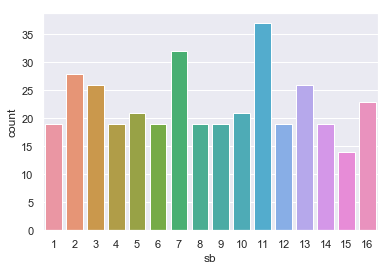

In [16]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_tr)

In [17]:
dict_sb_re = dict(df_re.sb.value_counts())
print(dict_sb_re)

{12: 31, 10: 27, 3: 27, 15: 25, 13: 25, 1: 25, 9: 24, 4: 24, 14: 23, 7: 23, 8: 21, 6: 21, 11: 20, 5: 16, 16: 15, 2: 14}


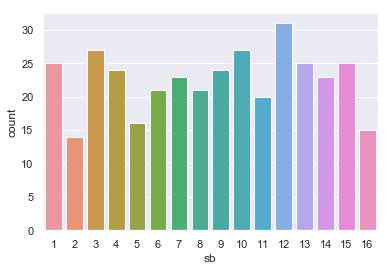

In [18]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df_sb_re)

In [19]:
dict_sb = dict(df.sb.value_counts())
print(dict_sb)

{11: 57, 7: 55, 3: 53, 13: 51, 12: 50, 10: 48, 1: 44, 9: 43, 4: 43, 14: 42, 2: 42, 8: 40, 6: 40, 15: 39, 16: 38, 5: 37}


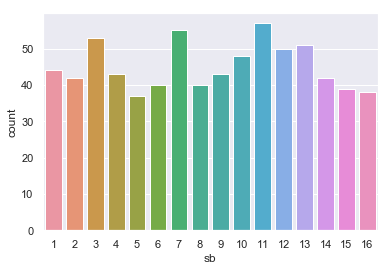

In [20]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sb", data=df)

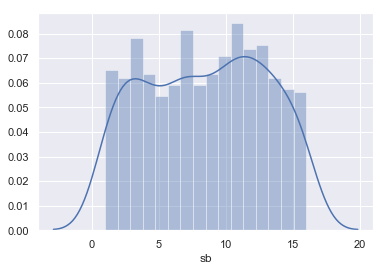

In [21]:
sns.set(style="darkgrid")
x= df.sb
ax = sns.distplot(x, bins=16)

In [22]:
#df.head()
categorical_cols = ['tipo','ganador']
unuseful_cols = ['fecha', 'nuevo']
le = LabelEncoder()

for item in categorical_cols[:]:
    if item == 'tipo' or item == 'ganador':
        nombre_col = str(item) + str('Tr')
        df_tr[nombre_col]= le.fit_transform(df_tr[item])
        nombre_col = str(item) + str('Re')
        df_re[nombre_col]= le.fit_transform(df_re[item])
#print(df_tr)
#print(df_re)


#df_tr = df_object.loc[:, (df.isin({"Tr"})).all(axis=0)]

C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
df_tr_fusion = []
df_re_fusion = []
print(df_tr)
df_tr_fusion = df_tr.drop(unuseful_cols, axis=1)
df_re_fusion = df_re.drop(unuseful_cols, axis=1)
print(df_tr_fusion)
df_tr_fu_filt = df_tr_fusion.iloc[:, [0,3,4,5,6,7,8]]
df_re_fu_filt = df_re_fusion.iloc[:, [0,3,4,5,6,7,8]]
Y_tr = df_tr_fusion.iloc[:, 10]
Y_re = df_re_fusion.iloc[:, 10]
filas = int(df_sb_tr.shape[0])
print(df_tr_fu_filt)
print(df_re_fu_filt)

     idSorteo      fecha tipo ganador nuevo  n1  n2  n3  n4  n5  sb  tipoTr  \
1        2031 2020-07-11   Tr      NO    SI  22  30  32  40  42  12       0   
3        2030 2020-04-11   Tr      NO    SI  22  26  29  30  39   7       0   
5        2029 2020-10-31   Tr      NO    SI   1   2   5  16  23  11       0   
7        2028 2020-10-28   Tr      NO    SI   9  19  20  36  37  12       0   
9        2027 2020-10-24   Tr      NO    SI  19  20  28  40  42  13       0   
..        ...        ...  ...     ...   ...  ..  ..  ..  ..  ..  ..     ...   
712      1675 2017-06-05   Tr      NO    SI   1  20  36  39  43  10       0   
714      1674 2017-03-05   Tr      NO    SI   5   6   7  12  37   6       0   
716      1673 2017-04-29   Tr      NO    SI   6  19  25  28  36   1       0   
718      1672 2017-04-26   Tr      NO    SI   1   2  25  31  33  14       0   
720      1671 2017-04-22   Tr      NO    SI  15  28  36  37  41  10       0   

     ganadorTr  
1            0  
3            0  


In [24]:
def addcolumn(df):
    delta=[]
    for index, row in df.iterrows():
        delta.append(word_maker(row.n1, row.n2, row.n3, row.n4, row.n5))
    df['delta'] = delta
    return df

In [25]:
sorteos = df_tr_fu_filt.shape
print (df_tr_fu_filt)
print(range(sorteos[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
1        2031  22  30  32  40  42  12
3        2030  22  26  29  30  39   7
5        2029   1   2   5  16  23  11
7        2028   9  19  20  36  37  12
9        2027  19  20  28  40  42  13
..        ...  ..  ..  ..  ..  ..  ..
712      1675   1  20  36  39  43  10
714      1674   5   6   7  12  37   6
716      1673   6  19  25  28  36   1
718      1672   1   2  25  31  33  14
720      1671  15  28  36  37  41  10

[361 rows x 7 columns]
range(0, 361)


In [26]:
df_tr_fu_filt_1 = df_tr_fu_filt[(df_tr_fu_filt['n1']==1) & (df_tr_fu_filt['n2']==2)]
df_tr_fu_filt_2 = df_tr_fu_filt_1[df_tr_fu_filt_1['n2']==3]
#df_tr_fu_filt_1 = df_tr_fu_filt.filter(='10', axis=0)
sorteos2 = df_tr_fu_filt_1.shape
print (df_tr_fu_filt_1)

print(range(sorteos2[0]))

     idSorteo  n1  n2  n3  n4  n5  sb
5        2029   1   2   5  16  23  11
17       2023   1   2  15  36  39   4
262      1900   1   2   3  10  31   1
282      1890   1   2  22  29  42  16
572      1745   1   2   4   5  13  10
574      1744   1   2  33  34  41  10
640      1711   1   2  20  31  43   8
718      1672   1   2  25  31  33  14
range(0, 8)


#### Se definen los archivos a los que se exportaran los dataframes que incluyen los deltas Calculados  

In [27]:
df_tr_fu_filt = addcolumn(df_tr_fu_filt)
df_tr_fu_filt.to_csv(r'df_tr_fu_filt_delta.csv', header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='w')
print(df_tr_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb  delta
1        2031  22  30  32  40  42  12  HBHBV
3        2030  22  26  29  30  39   7  DCAIY
5        2029   1   2   5  16  23  11  ACKGT
7        2028   9  19  20  36  37  12  JAOAÑ
9        2027  19  20  28  40  42  13  AHLBS
..        ...  ..  ..  ..  ..  ..  ..    ...
712      1675   1  20  36  39  43  10  ROCDA
714      1674   5   6   7  12  37   6  AAEXK
716      1673   6  19  25  28  36   1  MFCHM
718      1672   1   2  25  31  33  14  AVFBK
720      1671  15  28  36  37  41  10  MHADP

[361 rows x 8 columns]


C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [28]:
df_re_fu_filt = addcolumn(df_re_fu_filt)
df_re_fu_filt.to_csv(r'df_re_fu_filt_delta.csv', header=['idSorteo','n1','n2','n3','n4', 'n5','sb','delta'], index=None, sep=',', mode='w')
print(df_re_fu_filt)

     idSorteo  n1  n2  n3  n4  n5  sb  delta
0        2031   3   8   9  23  35   8  EANLK
2        2030   4  12  13  24  32   6  HAKHÑ
4        2029   9  17  21  34  40   4  HDMFL
6        2028   2   5   7  12  22   8  CBEJV
8        2027   6  10  18  27  35  10  DHIHN
..        ...  ..  ..  ..  ..  ..  ..    ...
713      1675   3   5   8  20  24  14  BCLDU
715      1674   5  12  15  20  42  14  GCEUF
717      1673   8  21  22  37  38   4  MAÑAM
719      1672   9  12  16  28  38   1  CDLJN
721      1671   3   9  10  21  40  10  FAKRF

[361 rows x 8 columns]


C:\Users\Ricardo\.conda\envs\dsbasic\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
#sorteo = df_tr_fu_filt[df_tr_fu_filt.idSorteo == '198']
#print(sorteo)
#df_tr_fu_filt.loc['n1'].tolist()
#idSorteo = '1975'
#values = df_tr_fu_filt.loc[idSorteo].tolist()
#print(values)


#### Se hacen los conteos de  los deltas y sus ocurrencias (NM Con este listado se debe validar expresiones similares para determinar comportamiento y posibles semejanzas entre ellos Ej MCACV similar a MCBCV, debe validarse que porcion de una expresion esta en la otras, a futuro deberia validarse la correlacion entre sorteo TR y sorteo RE )

In [30]:
df_tr_fu_filt.delta.value_counts()

MCACV    2
CDBOQ    1
EEEBY    1
OCCLI    1
FCCIU    1
        ..
ÑGCHJ    1
GKFBP    1
IIADS    1
AZCIC    1
DCAIY    1
Name: delta, Length: 360, dtype: int64

In [31]:
df_re_fu_filt.delta.value_counts()

MKDAN    2
GAMFO    1
HAKHÑ    1
ERFAL    1
NDGCÑ    1
        ..
GMBAS    1
GARBN    1
CANML    1
MCFIL    1
CCÑFO    1
Name: delta, Length: 360, dtype: int64

In [32]:
#def transforma_unos(df_tr_fu_filt)
#    for i in range(0, df_tr_fu_filt.shape[1])
        


#### Los numeros de las columnas n1-n5 seran fusionadas, seran transformados a una sola dimension, para poder determinar la frecuencia con la que acontecen, en primera instancia seran separados por tipo de sorteo, y en el nuevo dataset tendremos el numero del sorteo y el numero

In [33]:
#print(Y_tr)
#print(Y_re)
main_columns = ['n1','n2','n3', 'n4', 'n5', 'sb','tipo', 'ganador']

#### Este contenido se usa para segmentar el dataframe en los siguientes contextos single, duplas, ternas cuartetos y quintetos con y sin superbalota

In [34]:
def cortasingles(df, col0, col1):
    df_filt = df.iloc[0::1,[col0, col1]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [35]:
def cortasinglessb(df, col0, col1, sb):
    df_filt = df.iloc[0::1,[col0, col1, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [36]:
def cortatrios(df, col0, col1, col2, col3):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [37]:
def cortatriossb(df, col0, col1, col2, col3, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [38]:
def cortacuartetos(df, col0, col1, col2, col3, col4):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [39]:
def cortacuartetossb(df, col0, col1, col2, col3, col4, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [40]:
def cortaquintetos(df, col0, col1, col2, col3, col4, col5):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [41]:
def cortaquintetossb(df, col0, col1, col2, col3, col4, col5, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, col3, col4, col5, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

#### El siguiente contenido se usa para fusionar los dataframes desde los diferentes enfoques, singles, duplas, trios, etc

In [42]:
def concatenador_singles(df, sb):
    colid = 0
    df_1d_fu_tr = cortasinglessb(df,colid,1, sb) if sb > 0 else cortasingles(df,colid,1)
    inicial = 0
    for i in range(1,6):
        df_temp_fusion = cortasinglessb(df, colid, i, sb) if sb > 0 else cortasingles(df, colid, i)
        if (inicial == 0):
            df_1d_fu_tr = df_temp_fusion
            inicial += 1
        else :
            df_1d_fu_tr = pd.concat([df_1d_fu_tr, df_temp_fusion], ignore_index=True)
    df_1d_fu_tr.columns = ['idSorteo', 'num1', 'sb'] if sb > 0 else ['idSorteo', 'num1']
    return df_1d_fu_tr

In [43]:
def concatenador_duplas(df,sb):
    colid = 0
    inicial = 0
    for i in range(1,6):
        for ii in range(i+1, 6):
            df_temp_fusion = cortaduplassb(df, colid, i, ii, sb) if sb > 0 else cortaduplas(df, colid, i, ii)
            if (inicial == 0):
                df_2d_fu_tr = df_temp_fusion
                inicial += 1
            else :
                df_2d_fu_tr = pd.concat([df_2d_fu_tr, df_temp_fusion], ignore_index=True)
    df_2d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2']
    return df_2d_fu_tr

In [44]:
def concatenador_trios(df,sb):
    colid = 0
    df_3d_fu_tr = cortatriossb(df, colid, 1, 2, 3, sb) if sb > 0 else cortatrios(df, colid, 1, 2, 3)
    inicial = 0
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6):
                df_temp_fusion = cortatriossb(df, colid, i, ii, iii, sb) if sb > 0 else cortatrios(df, colid, i, ii, iii)
                if (inicial == 0):
                    df_3d_fu_tr = df_temp_fusion
                    inicial += 1
                else :
                    df_3d_fu_tr = pd.concat([df_3d_fu_tr, df_temp_fusion], ignore_index=True)
    df_3d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3']
    return df_3d_fu_tr

In [45]:
def concatenador_cuartetos(df, sb):
    colid = 0
    inicial = 0
    for i in range(1,6):
        for ii in range(i + 1, 6):
            for iii in range(ii + 1, 6 ):
                for iiii in range(iii + 1, 6 ):
                    df_temp_fusion = cortacuartetossb(df, colid, i, ii, iii, iiii, sb) if sb > 0 else cortacuartetos(df, colid, i, ii, iii, iiii)
                    if (inicial == 0):
                        df_4d_fu_tr = df_temp_fusion
                        inicial += 1
                    else :
                        df_4d_fu_tr = pd.concat([df_4d_fu_tr, df_temp_fusion], ignore_index=True)
    df_4d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4']
    return df_4d_fu_tr

In [46]:
def concatenador_quintetos(df, sb):
    colid = 0
    df_5d_fu_tr = cortaquintetossb(df, colid, 1, 2, 3, 4, 5, sb) if sb > 0 else  cortaquintetos(df, colid, 1, 2, 3, 4, 5)
    df_5d_fu_tr.columns = ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5', 'sb'] if sb > 0 else ['idSorteo', 'num1', 'num2', 'num3', 'num4', 'num5']
    return df_5d_fu_tr

In [47]:
def tuple_maker(ent1, ent2, ent3, ent4, ent5, cant):
    listik = []
    if (cant >= 1):
        listik.append(str(ent1))
    if (cant >= 2):       
        listik.append("|" + str(ent2))
    if (cant >= 3):
        listik.append("|" + str(ent3))
    if (cant >= 4):
        listik.append("|" + str(ent4))
    if (cant >= 5):
        listik.append("|" + str(ent5))
    palabra = "".join(listik)
    return palabra

#### Con la siguiente funcion adicionamos una nueva columna 'la de las tuplas'

In [48]:
def addcolumntuplas(df, cant):
    tupla=[]
    val_defecto = 0
    df.to_frame()
    df2 = df.rename(None).to_frame().T
    for index, row in df2.iteritems():
        if (cant == 1): 
            tupla.append(tuple_maker(index, val_defecto, val_defecto, val_defecto, val_defecto, cant)) 
        if (cant == 2):
            tupla.append(tuple_maker(index[0], index[1], val_defecto, val_defecto, val_defecto, cant))
        if (cant == 3): 
            tupla.append(tuple_maker(index[0], index[1], index[2], val_defecto, val_defecto, cant))  
        if (cant == 4): 
            tupla.append(tuple_maker(index[0], index[1], index[2], index[3], val_defecto, cant))  
        if (cant == 5): 
            tupla.append(tuple_maker(index[0], index[1], index[2], index[3], index[4], cant))  
    dft = df2.T
    dft['tupla'] = tupla
    dft = dft.reset_index(drop=True)
    return dft

In [49]:
def cortaduplas(df, col0, col1, col2):
    df_filt = df.iloc[0::1,[col0, col1, col2]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

In [50]:
def cortaduplassb(df, col0, col1, col2, sb):
    df_filt = df.iloc[0::1,[col0, col1, col2, sb]]
    df_filt = df_filt.rename(columns = {'n1':'num','n2':'num','n3':'num','n4':'num','n5':'num'})
    return df_filt

#### Se definen los metodos para agrupar el contenido del dataframe en grupos de acuerdo a cantidad de numeros involucrados

In [51]:
def agrupa_duplas(df):
    #print("dataframe en agrupa_duplas", df)
    conteo_nums = df.groupby(['num1', 'num2']).size()
    print("conteo_nums", conteo_nums)
    tupla  = []
    df = addcolumntuplas(conteo_nums, 2)
    df.columns = ['conteo','tupla']
    return df

In [52]:
df_2d_fusion_tr = concatenador_duplas(df_tr_fu_filt, 0)
#print("df_2d_fusion_tr ", df_2d_fusion_tr)
#df_2d_fusion_tr.to_csv(r'df_2d_fusion_tr.csv', header=['idSorteo','num1', 'num2'], index=None, sep=',', mode='w')
conteos_2d_tr = agrupa_duplas(df_2d_fusion_tr)
conteos_2d_tr.to_csv(r'conteos_2d_tr.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

conteo_nums num1  num2
1     2       8
      3       4
      4       9
      5       6
      6       3
             ..
40    42      5
      43      1
41    42      3
      43      3
42    43      3
Length: 892, dtype: int64


In [53]:
def agrupa_singles(df):
    conteo_nums = df.groupby(['num1']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 1)
    df.columns = ['conteo','tupla']
    return df

In [54]:
def agrupa_trios(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 3)
    df.columns = ['conteo','tupla']
    return df

In [55]:
def agrupa_cuartetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 4)
    df.columns = ['conteo','tupla']
    return df

In [56]:
def agrupa_quintetos(df):
    conteo_nums = df.groupby(['num1', 'num2', 'num3', 'num4', 'num5']).size()
    tupla  = []
    df = addcolumntuplas(conteo_nums, 5)
    df.columns = ['conteo','tupla']
    return df

#### Aquí se hace la separacion a un dataframe de solo 1 numero

In [57]:
df_1d_fusion_tr = concatenador_singles(df_tr_fu_filt, 0)
conteos_1d_tr = agrupa_singles(df_1d_fusion_tr)
conteos_1d_tr.to_csv(r'conteos_1d_tr.csv', header=['conteo','tupla'], index=None, sep=',', mode='w') 

In [58]:
df_1d_fusion_re = concatenador_singles(df_re_fu_filt, 0)
conteos_1d_re = agrupa_singles(df_1d_fusion_re)
conteos_1d_re.to_csv(r'conteos_1d_re.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [59]:
#sns.set(style="darkgrid")
#ax = sns.countplot(y="tupla", data=conteos_2d_tr)

In [60]:
df_2d_fusion_re = concatenador_duplas(df_re_fu_filt, 0)
conteos_2d_re = agrupa_duplas(df_2d_fusion_re)
conteos_2d_re.to_csv(r'conteos_2d_re.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

conteo_nums num1  num2
1     2       4
      3       3
      4       4
      5       9
      6       2
             ..
40    42      4
      43      4
41    42      3
      43      7
42    43      3
Length: 885, dtype: int64


In [61]:
#sns.set(style="darkgrid")
#ax = sns.countplot(y="tupla", data=conteos_2d_re)

In [62]:
df_3d_fusion_tr = concatenador_trios(df_tr_fu_filt, 0)
conteos_3d_tr = agrupa_trios(df_3d_fusion_tr)
conteos_3d_tr.to_csv(r'conteos_3d_tr.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [63]:
df_3d_fusion_re = concatenador_trios(df_re_fu_filt, 0)
conteos_3d_re = agrupa_trios(df_3d_fusion_re)
conteos_3d_re.to_csv(r'conteos_3d_re.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [64]:
df_4d_fusion_tr = concatenador_cuartetos(df_tr_fu_filt,0)
conteos_4d_tr = agrupa_cuartetos(df_4d_fusion_tr)
conteos_4d_tr.to_csv(r'conteos_4d_tr.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [65]:
df_4d_fusion_re = concatenador_cuartetos(df_re_fu_filt,0)
conteos_4d_re = agrupa_cuartetos(df_4d_fusion_re)
conteos_4d_re.to_csv(r'conteos_4d_re.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [66]:
df_5d_fusion_tr = concatenador_quintetos(df_tr_fu_filt, 0)
conteos_5d_tr = agrupa_quintetos(df_5d_fusion_tr)
conteos_5d_tr.to_csv(r'conteos_5d_tr.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [67]:
df_5d_fusion_re = concatenador_quintetos(df_re_fu_filt, 0)
conteos_5d_re = agrupa_quintetos(df_5d_fusion_re)
conteos_5d_re.to_csv(r'conteos_5d_re.csv', header=['conteo','tupla'], index=None, sep=',', mode='w')

In [68]:
df_final = df_3d_fusion_tr

In [69]:
df_final.describe()

,idSorteo,num1,num2,num3
count,3610.000,3610.000,3610.000,3610.000
mean,1851.000,10.918,21.839,33.183
std,104.226,8.132,9.470,8.402
min,1671.000,1.000,2.000,3.000
25%,1761.000,4.000,14.000,28.000
50%,1851.000,9.000,22.000,35.000
75%,1941.000,16.000,29.000,40.000
max,2031.000,39.000,42.000,43.000


In [70]:
#sns.set(style="darkgrid")
#ax = sns.countplot(y="num", data=df_final)

In [71]:
#sns.set(style="darkgrid")
#x= df_final.num
#ax = sns.distplot(x, bins=43)

TypeError: unsupported operand type(s) for /: 'str' and 'float'

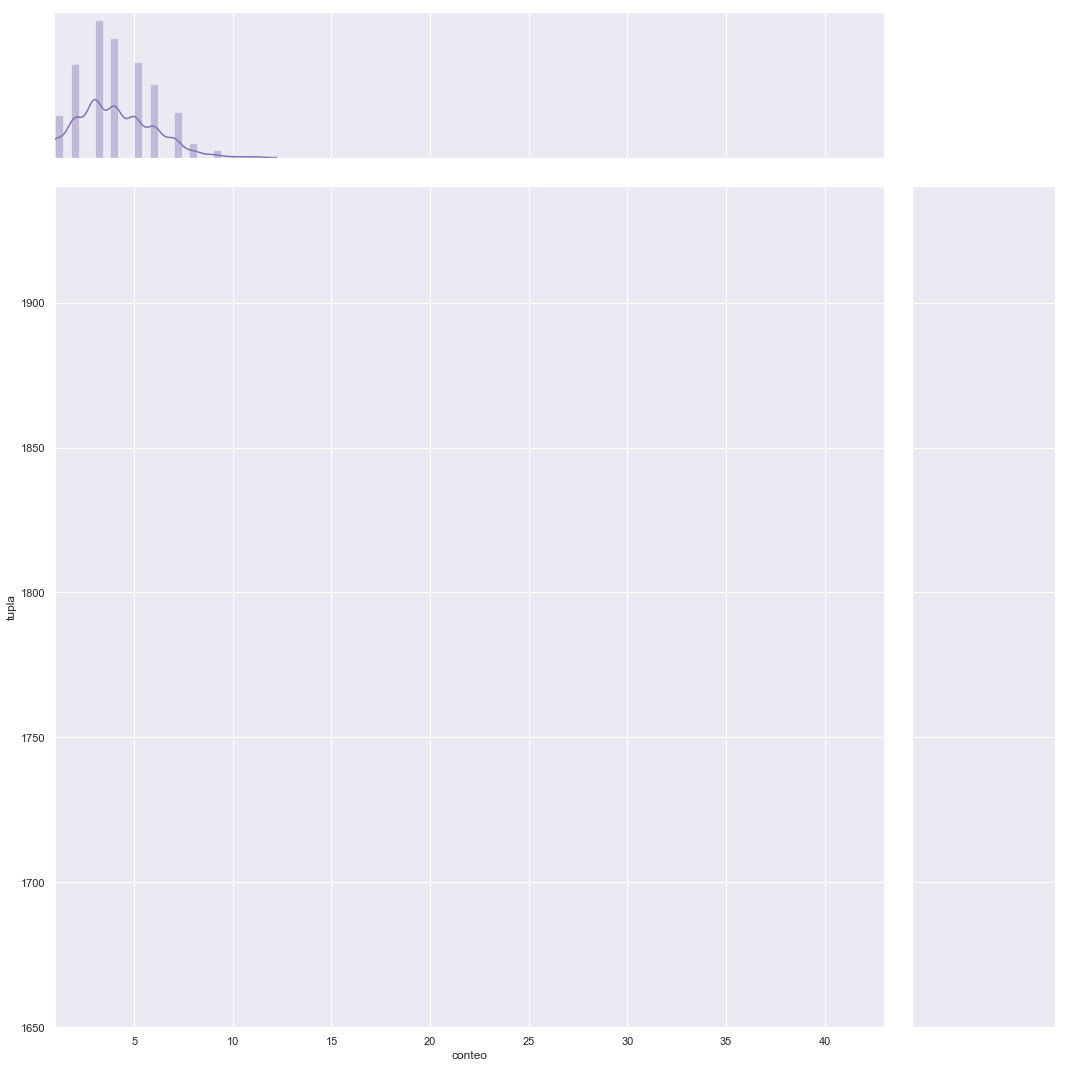

In [72]:
#df_topes = df_tr_fu_filt_delta.iloc[0::1,[0]]
g = sns.jointplot("conteo", "tupla",  data=conteos_2d_re, kind="reg", xlim=(1, 43), ylim=(1650, 1940), color="m", height=15)

In [ ]:
sns.pairplot(df_final, hue="num")

In [ ]:
grid = sns.FacetGrid(df_final, col="num", hue="num", palette="tab20c", col_wrap=4, height=4)
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, "num", "idSorteo", marker="o")
grid.set(xticks=np.arange(5), yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))
grid.fig.tight_layout(w_pad=1)

In [ ]:
a4_dims = (11.7, 8.27)
df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.violinplot(ax=ax, data=df, **violin_options)

ax = sns.barplot(x="num", y="num", data=df_final, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

In [ ]:
df_conteos = df_final.num.value_counts()
df_conteos.info()

In [ ]:
sns.set(style="darkgrid")
x= df_conteos.num
ax = sns.distplot(x, bins=43)